# Seq2Seq Seinfeld Chatbot

The architecture of the neural net was designed by Francois Chollet. 

In [64]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle

# Visualization library
import seaborn as sns

# NLP library
from nltk.tokenize import word_tokenize

### Data Cleaning

In [48]:
pwd

'/Users/alexander.fioto/github/Seinfeld-Chatbot/Seq2Seq'

In [50]:
# Loading in entire Seinfeld script
df = pd.read_csv('../data/scripts.csv', index_col=0)

In [51]:
df.head()

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,GEORGE,Are you through?,1.0,S01E01,1.0
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0


The dialogue has stage directions included, indicated by parentheses. I have decided to remove them to just model on pure dialogue.

In [52]:
# Remove parentheses
df['clean_dialogue'] = df['Dialogue'].str.replace(r"\(.*\)","")

In [53]:
# Seeing there is 10 dialogue cells that are NaNs
df.isna().sum()

Character          0
Dialogue          10
EpisodeNo          0
SEID               0
Season             0
clean_dialogue    10
dtype: int64

In [54]:
# Removing NaNs
df.dropna(inplace=True)

In [55]:
# Calculating the length of each line of dialogue
df['dialogue_len'] = df['Dialogue'].apply(lambda x: len(x))

In [56]:
# Calculating the word count of each line of dialogue
df['wordcount'] = df['clean_dialogue'].apply(lambda x: len(word_tokenize(x)))

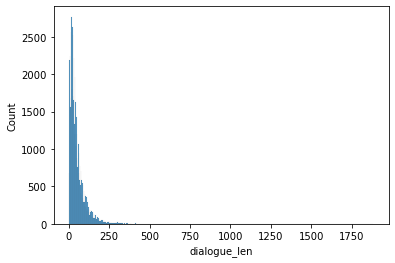

In [57]:
# Showing distribution of dialogue length in each line of dialogue
sns.histplot(data=df, x='dialogue_len');

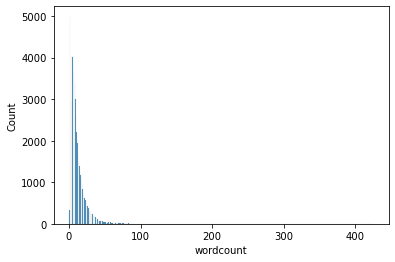

In [58]:
# Showing the distribution of word count in each line of dialogue
sns.histplot(data=df, x='wordcount');

There are a few lines of dialogue that are quite long! Most of these are probably Jerry's monologues at the beginning of the episodes. I will limit the length of lines to aid training. 

In [59]:
# Saving dataframe with dialogue length less than 50 characters
df = df[df['dialogue_len']< 50]

### Data Preparation

In this section the data is prepared for model. We need the data to be a list of lists with back and forth dialogue. 

In [60]:
# Creating a list of all dialogue
dialogue_list = list(df['clean_dialogue'])
dialogue_list[:5]

['Are you through?',
 'You do of course try on, when you buy?',
 'Oh, you dont recall?',
 'Mr. Seinfeld. Mr. Costanza.',
 'How come youre not doin the second show tomorrow?']

In [61]:
# Data preparation function
def seq_prep(dialogue):
    '''
    This function takes in a list of dialogue and returns a list
    of lists in the appropriate format for our seq2seq model.
    '''
    dialogue_combos = []
    for i in range(len(dialogue)+ 1):
        try:
            dialogue_combos.append([dialogue[i], dialogue[i+1]])
        except:
            pass
    return dialogue_combos

In [63]:
# Calling the function on the dialogue list
data = seq_prep(dialogue_list)

# Examining the first 5 rows
data[:8]

[['Are you through?', 'You do of course try on, when you buy?'],
 ['You do of course try on, when you buy?', 'Oh, you dont recall?'],
 ['Oh, you dont recall?', 'Mr. Seinfeld. Mr. Costanza.'],
 ['Mr. Seinfeld. Mr. Costanza.',
  'How come youre not doin the second show tomorrow?'],
 ['How come youre not doin the second show tomorrow?',
  'Well, theres this uh, woman might be comin in.'],
 ['Well, theres this uh, woman might be comin in.', 'No, you didnt!'],
 ['No, you didnt!', 'Ha.'],
 ['Ha.', ' So, you know, what, what happened?']]

In [22]:
# Saving the prepared data as a pickle file
with open('./data/seq2seq_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [65]:
# Reading the prepared data back in for retraining

with open('../data/seq2seq_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [66]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Setting the amount of data points to use
n = 2000

for line in data[:n]:
    # Defining an input document and a target document
    input_doc, target_doc = line[0], line[1]
    
    # Appending each input sentence to input_docs
    input_docs.append(input_doc)
    
    # Formatting target documents
    # Splitting words from punctuation  
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Adding <START> and <END> tags
    target_doc = '<START> ' + target_doc + ' <END>'
    # Appending each formated target to target documents
    target_docs.append(target_doc)
  
    # Splitting each sentence into words and adding to vocabulary
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        if token not in input_tokens:
            input_tokens.add(token)
    
    for token in target_doc.split():
        if token not in target_tokens:
            target_tokens.add(token)



In [67]:
print(input_docs[0])
print(target_docs[0])

Are you through?
<START> You do of course try on , when you buy ? <END>


In [68]:
# Creating a sorted list of all input tokens and target tokens
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Saving the length of vocabulary sets as variables. Encoder and Decoder
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum length of an input sentence and target sentence
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [69]:
print(f'Number of Encoder Tokens: {num_encoder_tokens}')
print(f'Number of Decoder Tokens: {num_decoder_tokens}')
print(f'Maximum Encoder Sequence Length: {max_encoder_seq_length}')
print(f'Maximum Decoder Sequence Length: {max_decoder_seq_length}')

Number of Encoder Tokens: 1654
Number of Decoder Tokens: 1657
Maximum Encoder Sequence Length: 21
Maximum Decoder Sequence Length: 27


In [70]:
# Creating four dictionaries

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

# Creating the reverse 
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

In [71]:
# Creating empty matricies for input data

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [72]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (2000, 21, 1654)
Decoder Input Data Shape: (2000, 27, 1657)
Decoder Target Data Shape: (2000, 27, 1657)


In [76]:
# This block of code sets up our data for input to the neural net.

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assigning 1.0 for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.0
        # Potential Conditional Statement

    for timestep, token in enumerate(target_doc.split()):
        # Assigning 1.0 for same in decoder_input_data
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.0
        if timestep > 0:
            
            # Setting the decoder target data for 1 previous timestep
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.0

## Neural Net Modeling

In [77]:
from tensorflow import keras

from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

latent_dim = 256
batch_size = 128
epochs = 100

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### The code below was used to train my training model. Implemented in Google Colab

In [78]:
callback = EarlyStopping(monitor='val_accuracy', patience=4)

training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    callbacks = callback)


Epoch 1/100
13/13 [==============================] - 6s 461ms/step - loss: 1.5911 - accuracy: 0.0381 - val_loss: 1.3905 - val_accuracy: 0.0395
Epoch 2/100
13/13 [==============================] - 6s 426ms/step - loss: 1.3268 - accuracy: 0.0460 - val_loss: 1.3912 - val_accuracy: 0.0447
Epoch 3/100
13/13 [==============================] - 5s 423ms/step - loss: 1.3035 - accuracy: 0.0485 - val_loss: 1.4013 - val_accuracy: 0.0529
Epoch 4/100
13/13 [==============================] - 6s 427ms/step - loss: 1.2906 - accuracy: 0.0501 - val_loss: 1.3984 - val_accuracy: 0.0509
Epoch 5/100
13/13 [==============================] - 6s 425ms/step - loss: 1.2766 - accuracy: 0.0510 - val_loss: 1.4076 - val_accuracy: 0.0445
Epoch 6/100
13/13 [==============================] - 6s 434ms/step - loss: 1.2703 - accuracy: 0.0513 - val_loss: 1.4140 - val_accuracy: 0.0545
Epoch 7/100
13/13 [==============================] - 6s 454ms/step - loss: 1.2615 - accuracy: 0.0536 - val_loss: 1.4198 - val_accuracy: 0.0519

In [80]:
pwd

'/Users/alexander.fioto/github/Seinfeld-Chatbot/Seq2Seq'

In [79]:
training_model.save('training_model.h5')

In [81]:
import matplotlib.pyplot as plt

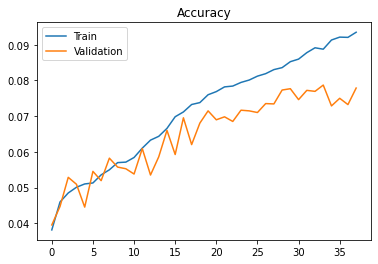

In [82]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

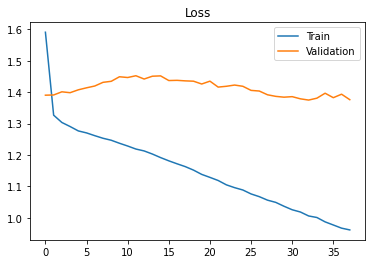

In [83]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

In [84]:
from tensorflow.keras.models import Model, load_model


# training_model = load_model('training_model.h5')

# encoder_inputs = training_model.input[0]
# encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
# encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [85]:
def string_to_matrix(user_input):
    '''This function takes in a string and outputs the corresponding matrix'''
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for timestep, token in enumerate(tokens):
        if token in input_features_dict:
            user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [86]:
def decode_sequence(test_input):
    '''This function takes in a sentence and returns the decoded sentence'''
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(string_to_matrix(test_input))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability and append it to decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence

In [87]:
# Example decoded sentence
decode_sequence('How are you?')

' You dont ? <END>'

In [88]:
class ChatBot:
    '''
    Utilizing the neural network architecture, this class employs a the Seinfeld Seq2Seq Chatbot. 
    '''
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")


    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", 'end')

    def start_chat(self):
        user_response = input("Hi, I'm a chatbot trained on dialog from Seinfeld. Would you like to chat with me?\n")
    
        if user_response.lower() in self.negative_responses:
            print("Ok, have a great day!")
            return
    
        user_response = input('Great!')
    
        self.chat(user_response)
  
    def chat(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply))
    

    def string_to_matrix(self, user_input):
        tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.

        return user_input_matrix

    def generate_response(self, user_input):
        input_matrix = self.string_to_matrix(user_input)
        states_value = encoder_model.predict(input_matrix)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, target_features_dict['<START>']] = 1.0
    
        chatbot_response = ''

        stop_condition = False

        while not stop_condition:

            output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_features_dict[sampled_token_index]
            chatbot_response += " " + sampled_token

            if (sampled_token == '<END>' or len(chatbot_response) > max_decoder_seq_length):
                stop_condition = True

                target_seq = np.zeros((1, 1, num_decoder_tokens))
                target_seq[0, 0, sampled_token_index] = 1.

            if '<END>' in chatbot_response:
                chatbot_response = chatbot_response.replace('<END>', '')

            punctuations = [' ?', ' .', ' !', ' ,']            
            for punctuation in punctuations:
                if punctuation in chatbot_response:
                    chatbot_response = chatbot_response.replace(punctuation, punctuation[-1])


            states_value = [hidden_state, cell_state]

        return chatbot_response
  
    def make_exit(self, reply):
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Ok, have a great day!")
                return True
            
        return False

In [90]:
# Chat!
chat = ChatBot()
chat.start_chat()

Hi, I'm a chatbot trained on dialog from Seinfeld. Would you like to chat with me?
 eys
Great! I like coffee.


KeyboardInterrupt: Interrupted by user